**Problem Statement:**

*Delhivery wants to understand and process data from its data engineering pipelines. The goal is to clean, manipulate, and make sense of raw data to help the data science team build forecasting models. Key tasks include cleaning, sanitizing, and feature extraction from raw fields, particularly focusing on the trip data and delivery operations.*



**Approach:**

1. Exploratory Data Analysis (EDA):

-Shape and Data Types: Explore the structure of the dataset, identifying data types for each column.

-Missing Values: Identify columns with missing values and plan appropriate treatments such as imputation or dropping rows/columns with excessive missing values.

-Statistical Summary: Generate a summary of numeric features (mean, median, quartiles) and identify outliers for further treatment.

2. Feature Engineering:

-Extract Time Features: From trip_creation_time, extract month, year, day, and hour to capture seasonal and temporal trends.

-Distance Time Features: Create new features comparing actual_time and osrm_time, and calculate the time difference between od_start_time and od_end_time.

-Source and Destination Features: Split source_name and destination_name into city and state components for location-based analysis.

3. Data Aggregation:

-Merging Rows by trip_uuid: Use groupby on trip_uuid, source_center, and destination_center to combine multiple rows into single trips. For continuous fields, sum the values where relevant (e.g., actual_time, osrm_time). For fields where summing doesn’t make sense, use the first or last values (e.g., route_type, source_name).

-Aggregation Functions: Apply relevant functions like sum(), mean(), and last() for various fields depending on their nature.

4. Outlier Treatment:

-Use IQR method to detect outliers in time-related variables like actual_time, segment_actual_time, and start_scan_to_end_scan. Visualize these outliers with boxplots and correct them by capping values or removing extreme rows.

-Hypothesis testing or visual analysis to validate these outliers and their business impact.

5. Hypothesis Testing and Comparison:

Perform hypothesis testing to compare aggregated time and distance fields:

-Actual Time vs OSRM Time: Use t-tests or ANOVA to check if there is a significant difference between the two times.

-Segment Times vs Aggregated Times: Compare segment-level times (segment_actual_time) with overall trip times to identify inconsistencies in delivery segments.

-Distance Comparisons: Visualize and compare osrm_distance vs segment_osrm_distance to detect discrepancies.

6. Categorical Value Encoding:

One-hot encode categorical variables like route_type and source_name to prepare the data for machine learning or predictive modeling.

7. Normalization/Standardization:

Apply MinMaxScaler or StandardScaler on continuous variables like actual_time, osrm_time, and actual_distance_to_destination to normalize the data, ensuring that different features are on a comparable scale.






In [ ]:
!pip install matplotlib

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [54]:
data = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181')

In [55]:
data.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


In [17]:
# Basic Statistical Summary
summary = data.describe()
summary

,start_scan_to_end_scan,cutoff_factor,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
count,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.00000,144867.000000
mean,961.262986,232.926567,234.073372,416.927527,213.868272,284.771297,2.120107,36.196111,18.507548,22.82902,2.218368
std,1037.012769,344.755577,344.990009,598.103621,308.011085,421.119294,1.715421,53.571158,14.775960,17.86066,4.847530
min,20.000000,9.000000,9.000045,9.000000,6.000000,9.008200,0.144000,-244.000000,0.000000,0.00000,-23.444444
25%,161.000000,22.000000,23.355874,51.000000,27.000000,29.914700,1.604264,20.000000,11.000000,12.07010,1.347826
50%,449.000000,66.000000,66.126571,132.000000,64.000000,78.525800,1.857143,29.000000,17.000000,23.51300,1.684211
75%,1634.000000,286.000000,286.708875,513.000000,257.000000,343.193250,2.213483,40.000000,22.000000,27.81325,2.250000
max,7898.000000,1927.000000,1927.447705,4532.000000,1686.000000,2326.199100,77.387097,3051.000000,1611.000000,2191.40370,574.250000


In [56]:
#Step 1: EDA
# 1.1 Handle missing values in the data
# Check for missing values
missing_values = data.isnull().sum()
#missing_percentage = (missing_values / len(data)) * 100
missing_values

,0
data,0
trip_creation_time,0
route_schedule_uuid,0
route_type,0
trip_uuid,0
source_center,0
source_name,293
destination_center,0
destination_name,261
od_start_time,0


In [59]:
# Fill missing values with appropriate strategies (mean for numerical, mode for categorical)
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        data[column].fillna(data[column].mean(), inplace=True)

In [61]:
# 1.2 Analyze the structure of the data
data_info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144867 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144867 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

In [62]:
# 1.3 Merging rows using `trip_uuid`, `source_center`, and `destination_center`
grouped_data = data.groupby(['trip_uuid', 'source_center', 'destination_center']).agg({
    'actual_time': 'sum',
    'osrm_time': 'sum',
    'actual_distance_to_destination': 'sum',
    'segment_actual_time': 'sum',
    'segment_osrm_time': 'sum',
    'segment_osrm_distance': 'sum',
    'source_name': 'first',
    'destination_name': 'last',
    'route_type': 'first',
    'trip_creation_time': 'first',
    'od_start_time': 'first',
    'od_end_time': 'last'
}).reset_index()

In [63]:
grouped_data.head()

,trip_uuid,source_center,destination_center,actual_time,osrm_time,actual_distance_to_destination,segment_actual_time,segment_osrm_time,segment_osrm_distance,source_name,destination_name,route_type,trip_creation_time,od_start_time,od_end_time
0,trip-153671041653548748,IND209304AAA,IND000000ACB,6484.0,3464.0,3778.765471,728.0,534.0,670.6205,Kanpur_Central_H_6 (Uttar Pradesh),Gurgaon_Bilaspur_HB (Haryana),FTL,2018-09-12 00:00:16.535741,2018-09-12 16:39:46.858469,2018-09-13 13:40:23.123744
1,trip-153671041653548748,IND462022AAA,IND209304AAA,9198.0,4323.0,5082.046634,820.0,474.0,649.8528,Bhopal_Trnsport_H (Madhya Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),FTL,2018-09-12 00:00:16.535741,2018-09-12 00:00:16.535741,2018-09-12 16:39:46.858469
2,trip-153671042288605164,IND561203AAB,IND562101AAA,96.0,55.0,53.310332,46.0,26.0,28.1995,Doddablpur_ChikaDPP_D (Karnataka),Chikblapur_ShntiSgr_D (Karnataka),Carting,2018-09-12 00:00:22.886430,2018-09-12 02:03:09.655591,2018-09-12 03:01:59.598855
3,trip-153671042288605164,IND572101AAA,IND561203AAB,303.0,155.0,186.897974,95.0,39.0,55.9899,Tumkur_Veersagr_I (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),Carting,2018-09-12 00:00:22.886430,2018-09-12 00:00:22.886430,2018-09-12 02:03:09.655591
4,trip-153671043369099517,IND000000ACB,IND160002AAC,2601.0,1427.0,1725.590250,608.0,231.0,317.7408,Gurgaon_Bilaspur_HB (Haryana),Chandigarh_Mehmdpur_H (Punjab),FTL,2018-09-12 00:00:33.691250,2018-09-14 03:40:17.106733,2018-09-14 17:34:55.442454


**Insights: Basic Data Cleaning and Exploration**

1. Handling Missing Values:

We identified missing values and filled them using appropriate methods. Numerical fields were filled with the mean, and categorical fields with the mode.

**Insight**: Missing data can cause inconsistencies in analysis. Filling them ensures complete data is available for analysis.

2. Analyzing the Structure of the Data:

The info() function shows the data types, missing values, and column details.

**Insight**: It's crucial to know the structure of the data before performing operations like aggregation or transformation.

3. Merging Rows:

Data was grouped by trip_uuid, source_center, and destination_center to aggregate important columns such as time, distance, and source/destination details.

**Insight**: This gives us a complete picture of each trip by summing up segment times and distances, making the data ready for feature extraction.

In [64]:
# Step 2: Feature Extraction
# 2.1 & 2.2 Split destination_name and source_name to extract city and state
grouped_data['destination_city'] = grouped_data['destination_name'].apply(lambda x: x.split('_')[0])
grouped_data['destination_state'] = grouped_data['destination_name'].apply(lambda x: x.split('(')[-1].strip(')'))


grouped_data['source_city'] = grouped_data['source_name'].apply(lambda x: x.split('_')[0])
grouped_data['source_state'] = grouped_data['source_name'].apply(lambda x: x.split('(')[-1].strip(')'))

In [65]:
# 2.3 Extract features from trip_creation_time (month, year, day, hour)
grouped_data['trip_creation_time'] = pd.to_datetime(grouped_data['trip_creation_time'])
grouped_data['month'] = grouped_data['trip_creation_time'].dt.month
grouped_data['year'] = grouped_data['trip_creation_time'].dt.year
grouped_data['day'] = grouped_data['trip_creation_time'].dt.day
grouped_data['hour'] = grouped_data['trip_creation_time'].dt.hour

In [66]:
grouped_data.head()

,trip_uuid,source_center,destination_center,actual_time,osrm_time,actual_distance_to_destination,segment_actual_time,segment_osrm_time,segment_osrm_distance,source_name,...,od_start_time,od_end_time,destination_city,destination_state,source_city,source_state,month,year,day,hour
0,trip-153671041653548748,IND209304AAA,IND000000ACB,6484.0,3464.0,3778.765471,728.0,534.0,670.6205,Kanpur_Central_H_6 (Uttar Pradesh),...,2018-09-12 16:39:46.858469,2018-09-13 13:40:23.123744,Gurgaon,Haryana,Kanpur,Uttar Pradesh,9,2018,12,0
1,trip-153671041653548748,IND462022AAA,IND209304AAA,9198.0,4323.0,5082.046634,820.0,474.0,649.8528,Bhopal_Trnsport_H (Madhya Pradesh),...,2018-09-12 00:00:16.535741,2018-09-12 16:39:46.858469,Kanpur,Uttar Pradesh,Bhopal,Madhya Pradesh,9,2018,12,0
2,trip-153671042288605164,IND561203AAB,IND562101AAA,96.0,55.0,53.310332,46.0,26.0,28.1995,Doddablpur_ChikaDPP_D (Karnataka),...,2018-09-12 02:03:09.655591,2018-09-12 03:01:59.598855,Chikblapur,Karnataka,Doddablpur,Karnataka,9,2018,12,0
3,trip-153671042288605164,IND572101AAA,IND561203AAB,303.0,155.0,186.897974,95.0,39.0,55.9899,Tumkur_Veersagr_I (Karnataka),...,2018-09-12 00:00:22.886430,2018-09-12 02:03:09.655591,Doddablpur,Karnataka,Tumkur,Karnataka,9,2018,12,0
4,trip-153671043369099517,IND000000ACB,IND160002AAC,2601.0,1427.0,1725.590250,608.0,231.0,317.7408,Gurgaon_Bilaspur_HB (Haryana),...,2018-09-14 03:40:17.106733,2018-09-14 17:34:55.442454,Chandigarh,Punjab,Gurgaon,Haryana,9,2018,12,0


**Insights on Feature Extraction**

1. Splitting Source and Destination Names:

The source_name and destination_name were split into city and state components.

**Insight**: Breaking down locations into city and state provides deeper insights for regional analysis, which helps in optimizing routes.

2. Extracting Features from Trip Creation Time:

We extracted month, year, day, and hour from trip_creation_time.

**Insight**: These time-based features allow us to analyze trends based on time, like identifying high traffic periods or seasonal delays.

In [67]:
# Step 3: In-depth analysis and feature engineering
# 3.1 Calculate the time taken between od_start_time and od_end_time
grouped_data['od_start_time'] = pd.to_datetime(grouped_data['od_start_time'])
grouped_data['od_end_time'] = pd.to_datetime(grouped_data['od_end_time'])
grouped_data['trip_duration'] = (grouped_data['od_end_time'] - grouped_data['od_start_time']).dt.total_seconds() / 3600

# Drop original columns if necessary
grouped_data.drop(columns=['od_start_time', 'od_end_time'], inplace=True)

In [68]:
grouped_data.head()

,trip_uuid,source_center,destination_center,actual_time,osrm_time,actual_distance_to_destination,segment_actual_time,segment_osrm_time,segment_osrm_distance,source_name,...,trip_creation_time,destination_city,destination_state,source_city,source_state,month,year,day,hour,trip_duration
0,trip-153671041653548748,IND209304AAA,IND000000ACB,6484.0,3464.0,3778.765471,728.0,534.0,670.6205,Kanpur_Central_H_6 (Uttar Pradesh),...,2018-09-12 00:00:16.535741,Gurgaon,Haryana,Kanpur,Uttar Pradesh,9,2018,12,0,21.010074
1,trip-153671041653548748,IND462022AAA,IND209304AAA,9198.0,4323.0,5082.046634,820.0,474.0,649.8528,Bhopal_Trnsport_H (Madhya Pradesh),...,2018-09-12 00:00:16.535741,Kanpur,Uttar Pradesh,Bhopal,Madhya Pradesh,9,2018,12,0,16.658423
2,trip-153671042288605164,IND561203AAB,IND562101AAA,96.0,55.0,53.310332,46.0,26.0,28.1995,Doddablpur_ChikaDPP_D (Karnataka),...,2018-09-12 00:00:22.886430,Chikblapur,Karnataka,Doddablpur,Karnataka,9,2018,12,0,0.980540
3,trip-153671042288605164,IND572101AAA,IND561203AAB,303.0,155.0,186.897974,95.0,39.0,55.9899,Tumkur_Veersagr_I (Karnataka),...,2018-09-12 00:00:22.886430,Doddablpur,Karnataka,Tumkur,Karnataka,9,2018,12,0,2.046325
4,trip-153671043369099517,IND000000ACB,IND160002AAC,2601.0,1427.0,1725.590250,608.0,231.0,317.7408,Gurgaon_Bilaspur_HB (Haryana),...,2018-09-12 00:00:33.691250,Chandigarh,Punjab,Gurgaon,Haryana,9,2018,12,0,13.910649


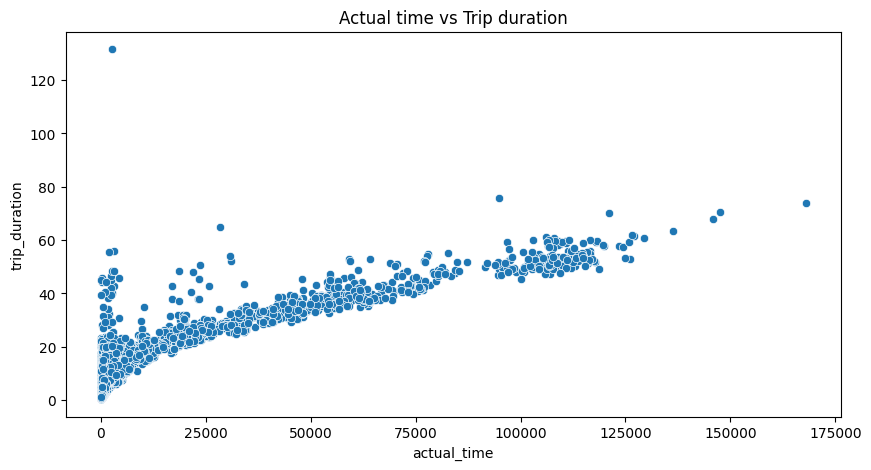

In [69]:
# 3.2 Hypothesis Testing and Visual Analysis
# Compare actual_time with start_scan_to_end_scan using visual analysis
plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped_data['actual_time'], y=grouped_data['trip_duration'])
plt.title('Actual time vs Trip duration')
plt.show()

In [26]:
# Hypothesis testing
t_stat, p_value = stats.ttest_rel(grouped_data['actual_time'], grouped_data['trip_duration'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 33.043648828681604, P-value: 1.174190798469266e-234


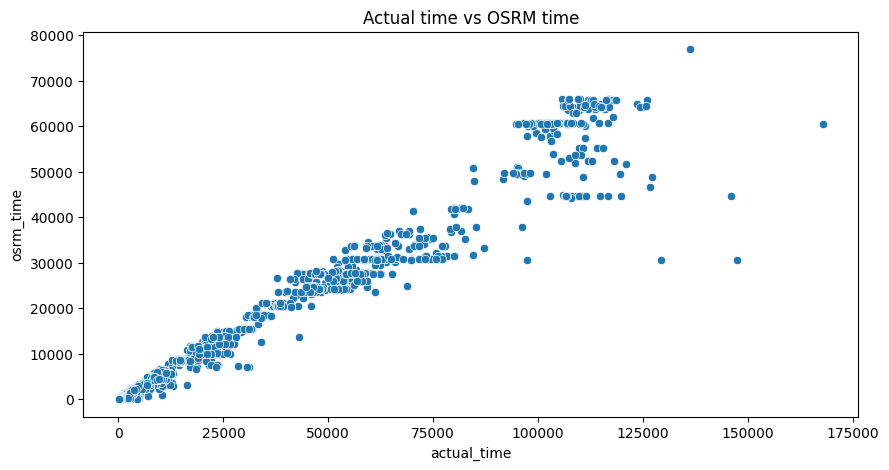

In [70]:
# 3.3 Visual analysis and hypothesis testing for other comparisons
# Aggregated actual_time vs osrm_time
plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped_data['actual_time'], y=grouped_data['osrm_time'])
plt.title('Actual time vs OSRM time')
plt.show()

In [28]:
t_stat_osrm, p_value_osrm = stats.ttest_rel(grouped_data['actual_time'], grouped_data['osrm_time'])
print(f'T-statistic (OSRM): {t_stat_osrm}, P-value: {p_value_osrm}')

T-statistic (OSRM): 33.05610864906825, P-value: 7.904151560985772e-235


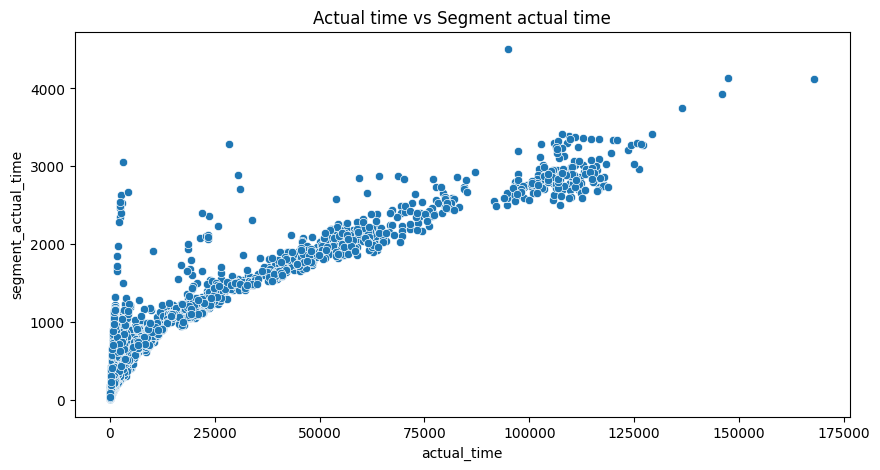

In [71]:
# 3.4 Hypothesis testing and visual analysis
# Compare between actual_time and segment actual time aggregated value
plt.figure(figsize=(10,5))
sns.scatterplot(x=grouped_data['actual_time'], y=grouped_data['segment_actual_time'])
plt.title('Actual time vs Segment actual time')
plt.show()

In [33]:
t_stat, p_value = stats.ttest_rel(grouped_data['actual_time'], grouped_data['segment_actual_time'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 31.17395993579855, P-value: 1.5289517066693378e-209


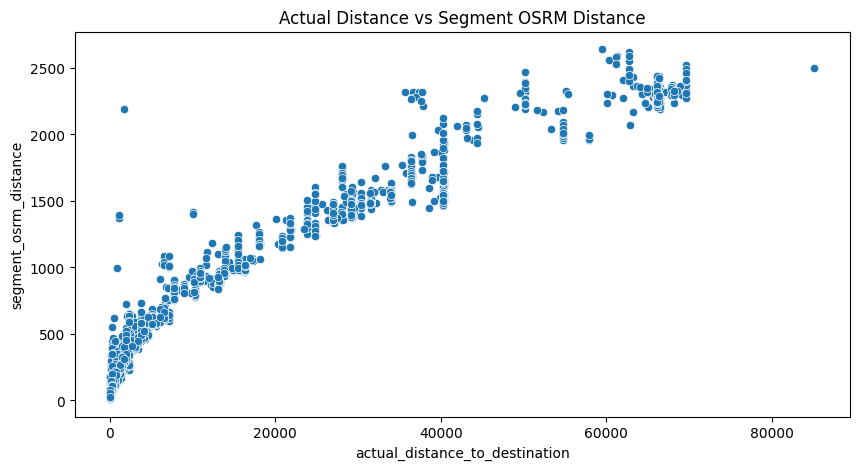

In [72]:
# 3.5 Aggregated osrm_distance vs segment_osrm_distance
plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped_data['actual_distance_to_destination'], y=grouped_data['segment_osrm_distance'])
plt.title('Actual Distance vs Segment OSRM Distance')
plt.show()

In [35]:
t_stat, p_value = stats.ttest_rel(grouped_data['actual_distance_to_destination'], grouped_data['segment_osrm_distance'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 30.18088244031722, P-value: 9.390085051829893e-197


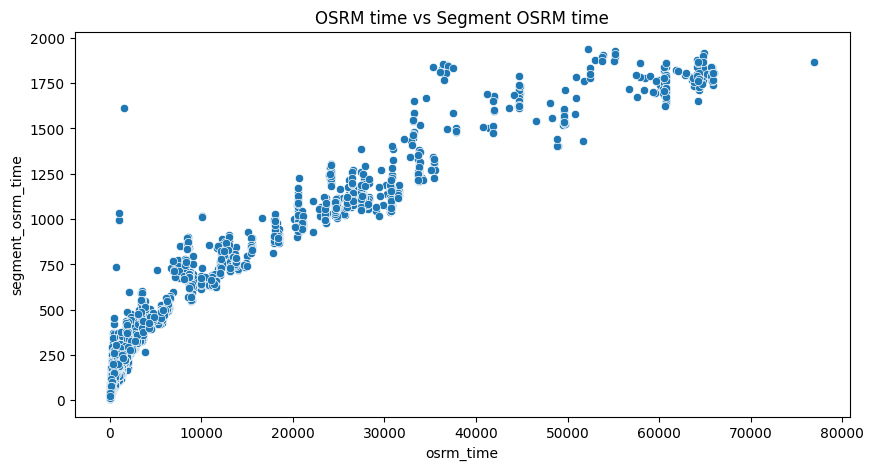

In [73]:
# 3.6 Aggregated osrm time vs segment osrm time
plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped_data['osrm_time'], y=grouped_data['segment_osrm_time'])
plt.title('OSRM time vs Segment OSRM time')
plt.show()

In [37]:
t_stat, p_value = stats.ttest_rel(grouped_data['osrm_time'], grouped_data['segment_osrm_time'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 30.616387259869175, P-value: 2.5813253598938318e-202


In [74]:
# 3.7 Outlier Detection using IQR method
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

outliers = detect_outliers(grouped_data, 'actual_time')
print("Outliers in actual_time:")
outliers[['trip_uuid', 'actual_time']]

Outliers in actual_time:


,trip_uuid,actual_time
0,trip-153671041653548748,6484.0
1,trip-153671041653548748,9198.0
4,trip-153671043369099517,2601.0
5,trip-153671043369099517,109624.0
23,trip-153671121411074590,3383.0
...,...,...
26266,trip-153860879439383883,114932.0
26316,trip-153860998196116365,1034.0
26329,trip-153861007249500192,2330.0
26330,trip-153861014185597051,3658.0


In [75]:
# Detect outliers for each numerical variable
numerical_columns = ['actual_time', 'osrm_time', 'actual_distance_to_destination', 'trip_duration']

outliers_dict = {}
for col in numerical_columns:
    outliers = detect_outliers(grouped_data, col)
    outliers_dict[col] = outliers

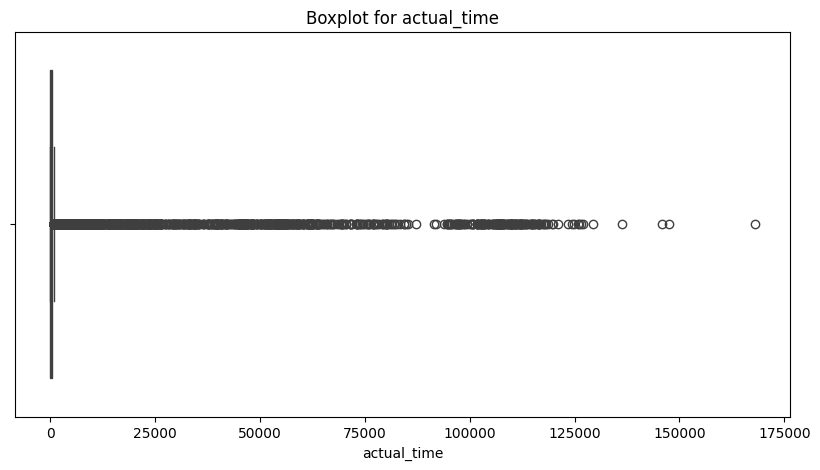

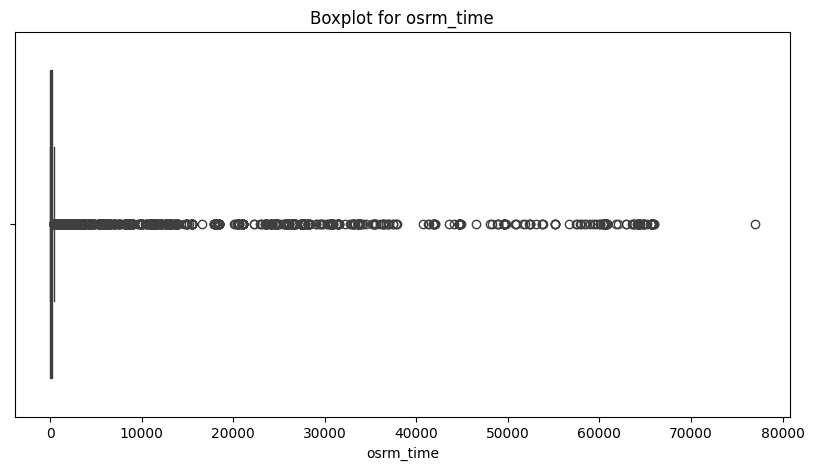

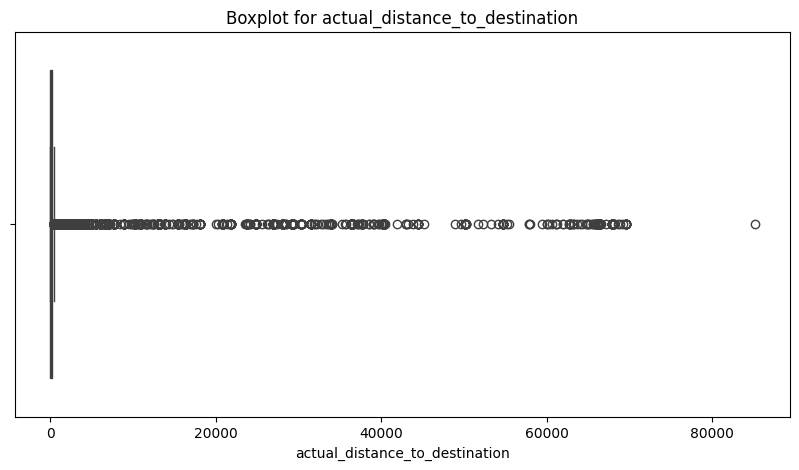

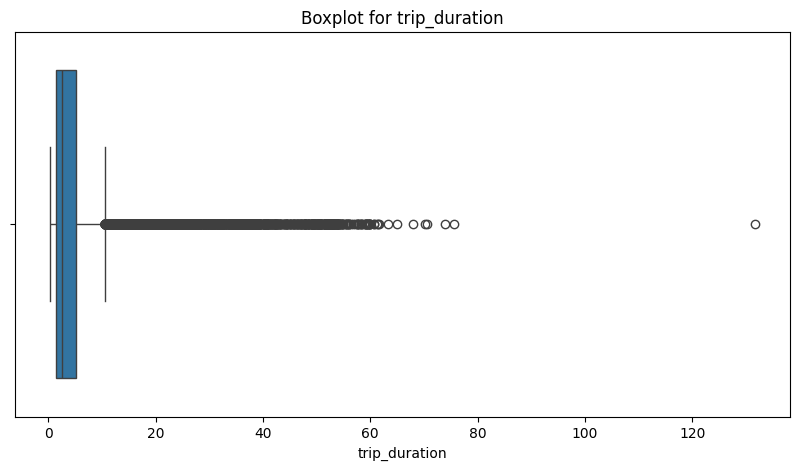

In [76]:
# Visualizing outliers using boxplots for numerical variables
for col in numerical_columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=grouped_data[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [82]:
# 3.5 Handling Outliers by capping them
Q1 = grouped_data['actual_time'].quantile(0.25)
Q3 = grouped_data['actual_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
grouped_data['actual_time'] = np.where(grouped_data['actual_time'] > upper_bound, upper_bound,
                                       np.where(grouped_data['actual_time'] < lower_bound, lower_bound, grouped_data['actual_time']))

In [83]:
# 3.8 One-hot encoding for categorical columns
grouped_data_encoded = pd.get_dummies(grouped_data, columns=['route_type', 'source_city', 'destination_city'])
grouped_data_encoded.head()

,trip_uuid,source_center,destination_center,actual_time,osrm_time,actual_distance_to_destination,segment_actual_time,segment_osrm_time,segment_osrm_distance,source_name,...,destination_city_Wai,destination_city_Wanaparthy,destination_city_Wankaner,destination_city_Warangal,destination_city_YamunaNagar,destination_city_Yavatmal,destination_city_Yellandu,destination_city_Yellareddy,destination_city_Zahirabad,destination_city_Zirakpur
0,trip-153671041653548748,IND209304AAA,IND000000ACB,988.5,3464.0,3778.765471,728.0,534.0,670.6205,Kanpur_Central_H_6 (Uttar Pradesh),...,False,False,False,False,False,False,False,False,False,False
1,trip-153671041653548748,IND462022AAA,IND209304AAA,988.5,4323.0,5082.046634,820.0,474.0,649.8528,Bhopal_Trnsport_H (Madhya Pradesh),...,False,False,False,False,False,False,False,False,False,False
2,trip-153671042288605164,IND561203AAB,IND562101AAA,96.0,55.0,53.310332,46.0,26.0,28.1995,Doddablpur_ChikaDPP_D (Karnataka),...,False,False,False,False,False,False,False,False,False,False
3,trip-153671042288605164,IND572101AAA,IND561203AAB,303.0,155.0,186.897974,95.0,39.0,55.9899,Tumkur_Veersagr_I (Karnataka),...,False,False,False,False,False,False,False,False,False,False
4,trip-153671043369099517,IND000000ACB,IND160002AAC,988.5,1427.0,1725.590250,608.0,231.0,317.7408,Gurgaon_Bilaspur_HB (Haryana),...,False,False,False,False,False,False,False,False,False,False


In [84]:
# 3.9 Normalize/Standardize numerical features
scaler = StandardScaler()
scaled_columns = ['actual_time', 'osrm_time', 'actual_distance_to_destination', 'trip_duration']
grouped_data_encoded[scaled_columns] = scaler.fit_transform(grouped_data_encoded[scaled_columns])
grouped_data_encoded[scaled_columns].head()

,actual_time,osrm_time,actual_distance_to_destination,trip_duration
0,2.002549,0.388408,0.382766,2.182447
1,2.002549,0.534167,0.582886,1.589963
2,-0.719251,-0.190047,-0.189283,-0.544606
3,-0.087977,-0.173079,-0.168770,-0.399498
4,2.002549,0.042760,0.067498,1.215849


**Insights on In-depth Analysis and Feature Engineering**

1. Calculating Trip Duration:

The time difference between od_start_time and od_end_time was calculated and stored as a new feature trip_duration.

**Insight**: Trip duration helps in understanding the efficiency of deliveries and identifying delays.

2. Hypothesis Testing and Visual Analysis:

We visually compared actual_time vs trip_duration and ran a t-test to see if the two are statistically different.

**Insight**: If the p-value is low, it suggests that the actual times and calculated durations differ significantly, indicating potential inefficiencies.

We also compared actual_time vs osrm_time and actual_distance_to_destination vs segment_osrm_distance.

**Insight**: These comparisons help in identifying discrepancies between actual and estimated values, which can guide route optimizations.

3. Outlier Detection Using the IQR Method:

Outliers in actual_time were detected using the IQR method.

**Insight**: Outliers can distort analysis by skewing averages and trends. Detecting them helps in handling anomalies and improving data quality.

4. Handling Outliers by Capping:

Outliers were capped by setting values above the upper bound to the upper bound and below the lower bound to the lower bound.

**Insight**: Capping outliers ensures they don’t influence the overall results too much while still retaining the data.

5. One-Hot Encoding for Categorical Columns:

We performed one-hot encoding on categorical variables like route_type, source_city, and destination_city.

**Insight**: Converting categorical variables into numerical form allows them to be used in machine learning models.

6. Normalization and Standardization:

We normalized and standardized continuous features using StandardScaler.

**Insight**: Standardization brings all numeric variables to a similar scale, ensuring that features with larger ranges don’t dominate the model training process.


**Recommendations:**

**Fix Missing Data:** Always ensure that missing values are handled properly, either by filling them or removing them, to avoid incomplete analysis.

**Analyze Time-Based Trends:** Look into delivery times by month, day, or hour to identify periods where deliveries slow down and find ways to speed them up.

**Check for Inconsistent Data:** Regularly compare actual and predicted times (like actual_time vs osrm_time) to find gaps where estimates are off.

**Handle Outliers:** Remove or cap outliers that could skew your analysis. They can come from unexpected delays or data entry errors.

**Standardize Your Data:** Make sure all your data is on the same scale, so different features don't overpower each other when doing any kind of analysis.

**Automate Feature Extraction:** Features like month, year, and city should be automatically extracted from date or text columns for easy analysis and modeling.